In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import time # To time the parallel execution
import numba
from numba import njit

In [4]:

def rk4_step(func, t, y, h, params):
    """
    Performs a single 4th-order Runge-Kutta step. (Python version)
    """
    k1 = func(t, y, params)
    k2 = func(t + 0.5 * h, y + 0.5 * h * k1, params)
    k3 = func(t + 0.5 * h, y + 0.5 * h * k2, params)
    k4 = func(t + h, y + h * k3, params)
    return y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


def adaptive_rk4(func, y0, t0, tf, h0, tol, params, r_stop_crit=0.0, verbose=True):
    """
    Integrates a system of ODEs using an adaptive RK4 method. (Python version)

    This version stores all intermediate steps in Python lists, which is
    flexible but slow. It's used for parts (a) and (b).
    """
    # --- Integration parameters ---
    SAFETY_FACTOR = 0.9  # Safety factor for step size adjustment
    MAX_FACTOR = 2.0     # Maximum factor to increase step size
    MIN_FACTOR = 0.2     # Minimum factor to decrease step size
    MIN_STEP = 1e-12     # Absolute minimum step size
    MAX_STEP = 0.1       # Absolute maximum step size (can be tuned)
    # -------------------------------

    # Initialize lists to store results
    t_vals = [t0]
    y_vals = [y0]

    # Set initial state
    t = t0
    y = y0.copy()
    h = h0

    while t < tf:
        # Ensure we don't step past the final time
        if t + h > tf:
            h = tf - t

        # --- Step Doubling ---
        # 1. Perform one large step
        y1 = rk4_step(func, t, y, h, params)

        # 2. Perform two small steps
        y_mid = rk4_step(func, t, y, h / 2.0, params)
        y2 = rk4_step(func, t + h / 2.0, y_mid, h / 2.0, params)
        # ---------------------

        # 3. Estimate the error
        scale = np.abs(y2) + 1e-30  # Avoid division by zero
        error_ratio = (y1 - y2) / scale
        delta = np.linalg.norm(error_ratio)

        # 4. Check if error is within tolerance
        if delta <= tol or h <= MIN_STEP:
            # --- Accept Step ---
            t = t + h
            y = y2  # y2 is the more accurate (5th order) estimate

            # Store results
            t_vals.append(t)
            y_vals.append(y)

            # Check stopping condition (e.g., reaching r_s)
            current_r = np.sqrt(y[0]**2 + y[1]**2)
            if r_stop_crit > 0 and current_r <= r_stop_crit:
                if verbose:
                    print(f"Integration stopped: r = {current_r:.2e} <= r_stop = {r_stop_crit:.2e}")
                break

            # --- Adjust step size for next step ---
            if delta == 0.0:
                h_new_factor = MAX_FACTOR
            else:
                h_new_factor = SAFETY_FACTOR * (tol / delta)**0.2

            h_new_factor = min(MAX_FACTOR, max(MIN_FACTOR, h_new_factor))
            h = max(min(h * h_new_factor, MAX_STEP), MIN_STEP)

        else:
            # --- Reject Step ---
            h_new_factor = SAFETY_FACTOR * (tol / delta)**0.2
            h_new_factor = min(MAX_FACTOR, max(MIN_FACTOR, h_new_factor))
            h = max(min(h * h_new_factor, MAX_STEP), MIN_STEP)

    # Return results as NumPy arrays
    return np.array(t_vals), np.array(y_vals)

In [5]:
def derivs(t, y, params):
    x, y_pos, vx, vy = y  # y_pos to avoid conflict with y state vector

    # Get parameters
    A = params.get('A', 0.0)
    B = params.get('B', 1.0)

    # Calculate radius and velocity magnitudes
    r_sq = x**2 + y_pos**2
    r = np.sqrt(r_sq)
    r_cubed = r**3

    v_sq = vx**2 + vy**2
    v = np.sqrt(v_sq)

    # 1. Gravitational acceleration (from the other BH)
    ax_g = -1.0 / (4.0 * r_cubed) * x
    ay_g = -1.0 / (4.0 * r_cubed) * y_pos

    # 2. Dynamical Friction acceleration
    ax_df = 0.0
    ay_df = 0.0

    if A != 0.0 and v > 1e-15: # Avoid division by zero if v=0
        v_cubed = v**3
        df_factor = -A / (v_cubed + B)
        ax_df = df_factor * vx
        ay_df = df_factor * vy

    # Total acceleration
    ax = ax_g + ax_df
    ay = ay_g + ay_df

    return np.array([vx, vy, ax, ay])

In [18]:
# Parameters for part (a)
params_a = {'A': 0.0, 'B': 1.0}  # A=0 means no DF

# Initial conditions
y0 = np.array([1.0, 0.0, 0.0, 0.4])

# Integration settings
t0 = 0.0
h0 = 0.01  # Initial step size
TOLERANCE_A = 1e-9  # Strict tolerance for energy conservation check
R_STOP_CRIT_A = 0.0 # No stop criterion
T_orbit_est = 8.0
tf_a = 10 * T_orbit_est  # Integrate for 10 orbits

# Run the integration (standard Python version)
t_vals_a, y_vals_a = adaptive_rk4(derivs, y0, t0, tf_a, h0, TOLERANCE_A, params_a, r_stop_crit=R_STOP_CRIT_A, verbose=True)

print(f"Part (a) finished. Integrated {len(t_vals_a)} steps.")

# Calculate energy conservation
x_a = y_vals_a[:, 0]
y_a = y_vals_a[:, 1]
vx_a = y_vals_a[:, 2]
vy_a = y_vals_a[:, 3]
r_a = np.sqrt(x_a**2 + y_a**2)
v_sq_a = vx_a**2 + vy_a**2
E_total_a = 0.5 * v_sq_a - 1.0 / (4.0 * r_a)
E_init_a = E_total_a[0]
E_error_frac = (E_total_a - E_init_a) / E_init_a


print(f"Initial Energy: {E_init_a:.6f}")
print(f"Max Fractional Energy Error: {np.max(np.abs(E_error_frac)):.2e}")
print("\nDiscussion: The plot shows that the fractional energy error remains very small")
print(f"(on the order of {np.max(np.abs(E_error_frac)):.1e}) over 10 orbits.")
print(f"This demonstrates that our adaptive integrator with tolerance d={TOLERANCE_A:.1e}")
print("is accurate and conserves energy well for this problem.")

Part (a) finished. Integrated 2507 steps.
Initial Energy: -0.170000
Max Fractional Energy Error: 1.86e-09

Discussion: The plot shows that the fractional energy error remains very small
(on the order of 1.9e-09) over 10 orbits.
This demonstrates that our adaptive integrator with tolerance d=1.0e-09
is accurate and conserves energy well for this problem.


--- Plotting Orbital Path ---


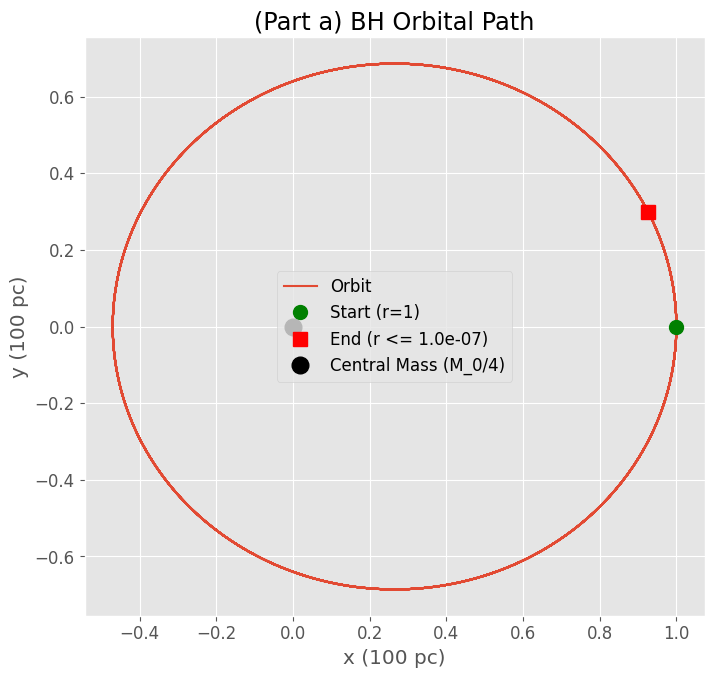

In [10]:
print("--- Plotting Orbital Path ---")
plt.figure(figsize=(8, 8))
plt.plot(x_a, y_a, label='Orbit')
plt.plot(x_a[0], y_a[0], 'go', markersize=10, label='Start (r=1)')
plt.plot(x_a[-1], y_a[-1], 'rs', markersize=10, label=f'End (r <= {R_SCHWARZSCHILD:.1e})')

# Plot the central mass
plt.plot(0, 0, 'ko', markersize=12, label='Central Mass (M_0/4)')

plt.xlabel("x (100 pc)")
plt.ylabel("y (100 pc)")
plt.title("(Part a) BH Orbital Path")
plt.gca().set_aspect('equal')
plt.legend()
plt.grid(True)
plt.show()

Integration stopped: r = 9.98e-08 <= r_stop = 1.00e-07
Part (b) finished. Reached r_s at t = 10.76


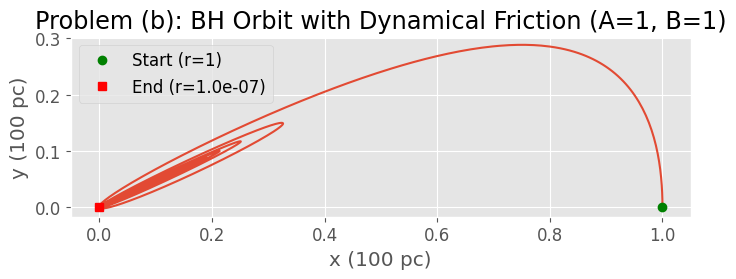

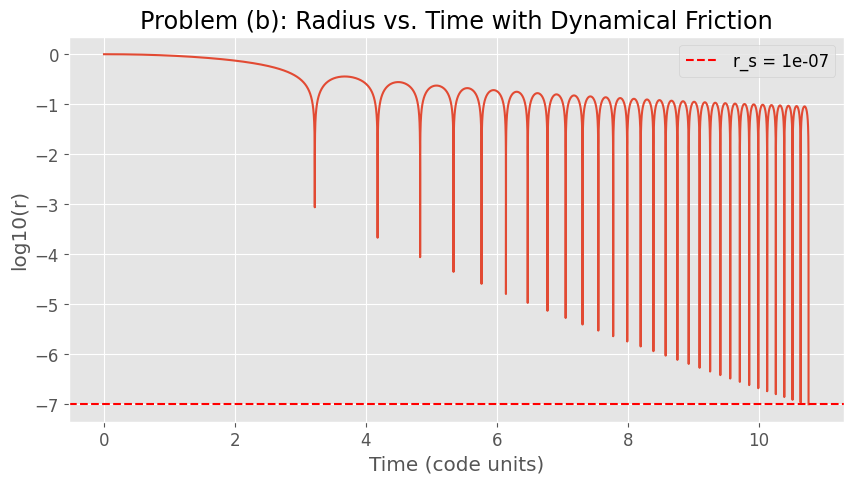

In [7]:
# Parameters for part (b)
params_b = {'A': 1.0, 'B': 1.0}
R_SCHWARZSCHILD = 1e-7
tf_b = 5000.0  # Set a long max time, it should stop at r_s

# Run the integration (standard Python version)
t_vals_b, y_vals_b = adaptive_rk4(derivs, y0, t0, tf_b, h0, TOLERANCE_A,
                                  params_b, r_stop_crit=R_SCHWARZSCHILD, verbose=True)

print(f"Part (b) finished. Reached r_s at t = {t_vals_b[-1]:.2f}")

# --- Plot 1: Orbital Path ---
x_b = y_vals_b[:, 0]
y_b = y_vals_b[:, 1]
plt.figure(figsize=(8, 8))
plt.plot(x_b, y_b)
plt.plot(x_b[0], y_b[0], 'go', label='Start (r=1)') # Start
plt.plot(x_b[-1], y_b[-1], 'rs', label=f'End (r={R_SCHWARZSCHILD:.1e})') # End
plt.xlabel("x (100 pc)")
plt.ylabel("y (100 pc)")
plt.title("Problem (b): BH Orbit with Dynamical Friction (A=1, B=1)")
plt.gca().set_aspect('equal')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: log(r) vs. t ---
r_b = np.sqrt(x_b**2 + y_b**2)
plt.figure(figsize=(10, 5))
plt.plot(t_vals_b, np.log10(r_b))
plt.axhline(y=np.log10(R_SCHWARZSCHILD), color='r', linestyle='--', label=f'r_s = {R_SCHWARZSCHILD:.0e}')
plt.xlabel("Time (code units)")
plt.ylabel("log10(r)")
plt.title("Problem (b): Radius vs. Time with Dynamical Friction")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
@njit
def derivs_numba(t, y, A, B):
    """
    Calculates the derivatives. (Numba-jitted version)
    Accepts A and B as direct arguments, not a dictionary.
    """
    x, y_pos, vx, vy = y

    r_sq = x**2 + y_pos**2
    r = np.sqrt(r_sq)
    r_cubed = r**3

    v_sq = vx**2 + vy**2
    v = np.sqrt(v_sq)

    # 1. Gravitational acceleration
    ax_g = -1.0 / (4.0 * r_cubed) * x
    ay_g = -1.0 / (4.0 * r_cubed) * y_pos

    # 2. Dynamical Friction acceleration
    ax_df = 0.0
    ay_df = 0.0

    if A != 0.0 and v > 1e-15:
        v_cubed = v**3
        df_factor = -A / (v_cubed + B)
        ax_df = df_factor * vx
        ay_df = df_factor * vy

    ax = ax_g + ax_df
    ay = ay_g + ay_df

    return np.array([vx, vy, ax, ay])

@njit
def rk4_step_numba(t, y, h, A, B):
    """
    Performs a single 4th-order Runge-Kutta step. (Numba-jitted version)
    Calls derivs_numba directly.
    """
    k1 = derivs_numba(t, y, A, B)
    k2 = derivs_numba(t + 0.5 * h, y + 0.5 * h * k1, A, B)
    k3 = derivs_numba(t + 0.5 * h, y + 0.5 * h * k2, A, B)
    k4 = derivs_numba(t + h, y + h * k3, A, B)
    return y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit
def integrate_to_stop(y0, t0, tf, h0, tol, A, B, r_stop_crit):
    """
    Integrates ODEs using adaptive RK4. (Numba-jitted version)

    This function is optimized for speed. It does *not* store
    intermediate results and returns *only* the final time, `t`.
    """
    # --- Integration parameters (must be defined inside njit function) ---
    SAFETY_FACTOR = 0.9
    MAX_FACTOR = 2.0
    MIN_FACTOR = 0.2
    MIN_STEP = 1e-12
    MAX_STEP = 0.1
    # -------------------------------

    t = t0
    y = y0.copy() # Ensure we don't modify the input array
    h = h0

    while t < tf:
        if t + h > tf:
            h = tf - t

        y1 = rk4_step_numba(t, y, h, A, B)
        y_mid = rk4_step_numba(t, y, h / 2.0, A, B)
        y2 = rk4_step_numba(t + h / 2.0, y_mid, h / 2.0, A, B)

        scale = np.abs(y2) + 1e-30

        delta_sq = 0.0
        for i in range(y1.shape[0]):
            err_ratio = (y1[i] - y2[i]) / scale[i]
            delta_sq += err_ratio * err_ratio
        delta = np.sqrt(delta_sq)

        if delta <= tol or h <= MIN_STEP:
            t = t + h
            y = y2

            # Check stopping condition
            current_r = np.sqrt(y[0]**2 + y[1]**2)
            if r_stop_crit > 0 and current_r <= r_stop_crit:
                break # Stop integration

            #  Adjust step size
            if delta == 0.0:
                h_new_factor = MAX_FACTOR
            else:
                h_new_factor = SAFETY_FACTOR * (tol / delta)**0.2

            h_new_factor = min(MAX_FACTOR, max(MIN_FACTOR, h_new_factor))
            h = max(min(h * h_new_factor, MAX_STEP), MIN_STEP)

        else:
            h_new_factor = SAFETY_FACTOR * (tol / delta)**0.2
            h_new_factor = min(MAX_FACTOR, max(MIN_FACTOR, h_new_factor))
            h = max(min(h * h_new_factor, MAX_STEP), MIN_STEP)

    return t

In [12]:
def run_simulation(args):
    A_c, B_c, y0_sim, t0_sim, tf_sim, h0_sim, tol_sim, r_stop_sim = args

    t_final = integrate_to_stop(y0_sim, t0_sim, tf_sim, h0_sim, tol_sim,
                                A_c, B_c, r_stop_sim)

    if t_final >= tf_sim:
        return np.nan
    else:
        return t_final

Using tolerance d=1.0e-06 for grid simulations.
Parallel execution finished in 22.30 seconds.

Time scale: 1 code unit = 1.49 Myr


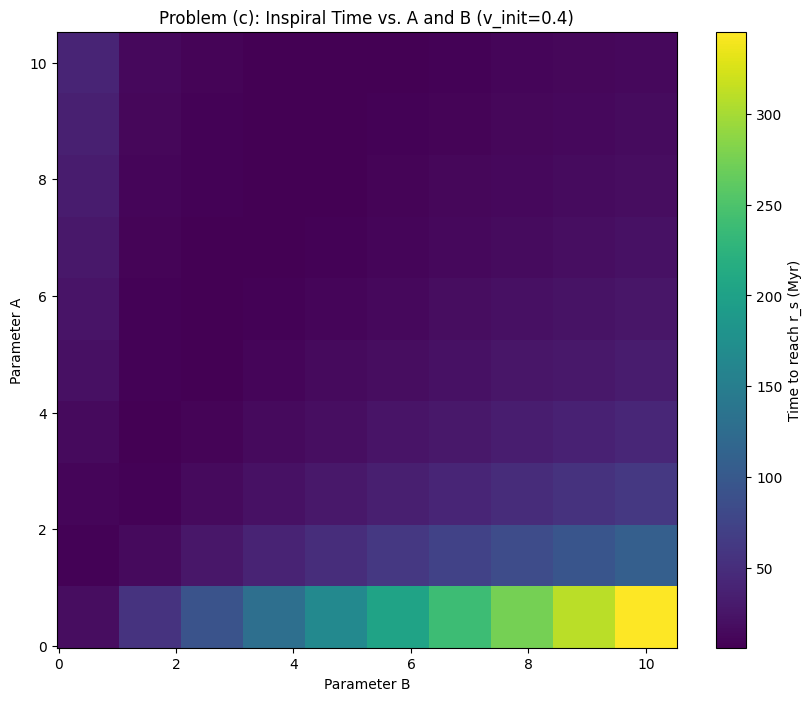

In [17]:
# Define the range of A and B
A_vals = np.linspace(0.5, 10.0, 10)
B_vals = np.linspace(0.5, 10.0, 10)

GRID_TOLERANCE = 1e-6

# 2D grid to store final times
t_final_grid_1 = np.zeros((len(A_vals), len(B_vals)))
tf_c = 20000.0  # Max time for these runs

# Create a list of tasks to run in parallel
tasks = []
for i, A_c in enumerate(A_vals):
    for j, B_c in enumerate(B_vals):
        # (A, B, y0, t0, tf, h0, tol, r_stop_crit)
        tasks.append((A_c, B_c, y0, t0, tf_c, h0, GRID_TOLERANCE, R_SCHWARZSCHILD))

start_time = time.time()

# Run tasks in parallel
with multiprocessing.Pool() as pool:
    results = pool.map(run_simulation, tasks)

end_time = time.time()
print(f"Parallel execution finished in {end_time - start_time:.2f} seconds.")

# Reshape the 1D results list into the 2D grid
t_final_grid_1 = np.array(results).reshape((len(A_vals), len(B_vals)))

# --- Convert time to Myr ---
G_phys = 6.674e-11  # SI units (m^3 kg^-1 s^-2)
M_sun_kg = 1.989e30 # kg
pc_m = 3.086e16     # m
M_0 = 1e8 * M_sun_kg  # Mass scale: 10^8 M_sun
r_0 = 100 * pc_m      # Distance scale: 100 pc
t_0_sec_sq = (r_0**3) / (G_phys * M_0)
t_0_sec = np.sqrt(t_0_sec_sq)
sec_per_yr = 3.154e7
sec_per_Myr = sec_per_yr * 1e6
TIME_SCALE_Myr = t_0_sec / sec_per_Myr

print(f"\nTime scale: 1 code unit = {TIME_SCALE_Myr:.2f} Myr")

# Apply the scaling
t_final_myr_grid_1 = t_final_grid_1 * TIME_SCALE_Myr

plt.figure(figsize=(10, 8))
# Use pcolormesh for a non-contoured heatmap
plt.pcolormesh(B_vals, A_vals, t_final_myr_grid_1, cmap='viridis', shading='auto')
plt.colorbar(label="Time to reach r_s (Myr)")
plt.xlabel("Parameter B")
plt.ylabel("Parameter A")
plt.title(f"Problem (c): Inspiral Time vs. A and B (v_init=0.4)")
plt.show()
